In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Загрузка данных
print("=== ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ ===")
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print(f"Размер исходных данных: {df.shape}")

# Предобработка
def preprocess_data(df):
    df_clean = df.copy()

    # Обработка TotalCharges
    df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
    df_clean['TotalCharges'].fillna(df_clean['TotalCharges'].median(), inplace=True)

    # Удаляем customerID
    df_clean = df_clean.drop('customerID', axis=1)

    # Кодируем целевую переменную
    df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

    # Кодируем категориальные признаки
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

    return df_encoded

df_processed = preprocess_data(df)
print(f"Размер после предобработки: {df_processed.shape}")
print(f"Целевая переменная распределение:\n{df_processed['Churn'].value_counts()}")

=== ЗАГРУЗКА И ПРЕДОБРАБОТКА ДАННЫХ ===
Размер исходных данных: (7043, 21)
Размер после предобработки: (7043, 31)
Целевая переменная распределение:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [ ]:
# Разделение на признаки и целевую переменную
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== РАЗДЕЛЕНИЕ ДАННЫХ ===")
print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

# Базовая модель (параметры по умолчанию)
print("\n=== БАЗОВАЯ МОДЕЛЬ (ДО ОПТИМИЗАЦИИ) ===")
base_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Кросс-валидация для базовой модели
cv_scores_before = cross_val_score(base_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"ROC-AUC на кросс-валидации: {cv_scores_before.mean():.4f} (+/- {cv_scores_before.std() * 2:.4f})")

# Обучаем и оцениваем базовую модель
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
y_prob_base = base_model.predict_proba(X_test)[:, 1]

# Метрики базовой модели
metrics_base = {
    'Accuracy': accuracy_score(y_test, y_pred_base),
    'Precision': precision_score(y_test, y_pred_base),
    'Recall': recall_score(y_test, y_pred_base),
    'F1-score': f1_score(y_test, y_pred_base),
    'ROC-AUC': roc_auc_score(y_test, y_prob_base)
}

print("Метрики базовой модели на тестовых данных:")
for metric, value in metrics_base.items():
    print(f"  {metric}: {value:.4f}")


=== РАЗДЕЛЕНИЕ ДАННЫХ ===
Обучающая выборка: (5634, 30)
Тестовая выборка: (1409, 30)

=== БАЗОВАЯ МОДЕЛЬ (ДО ОПТИМИЗАЦИИ) ===
ROC-AUC на кросс-валидации: 0.8218 (+/- 0.0253)
Метрики базовой модели на тестовых данных:
  Accuracy: 0.7850
  Precision: 0.6079
  Recall: 0.5348
  F1-score: 0.5690
  ROC-AUC: 0.8214


In [ ]:
print("\n=== ОПРЕДЕЛЕНИЕ ДИАПАЗОНОВ ГИПЕРПАРАМЕТРОВ ===")

# Для GridSearchCV (ограниченный набор)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Для RandomizedSearchCV (широкий диапазон)
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 1.5, 2.0]
}

print(f"GridSearchCV: {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['subsample'])} комбинаций")
print(f"RandomizedSearchCV: 50 случайных комбинаций из {np.prod([len(v) for v in param_distributions.values()])} возможных")


=== ОПРЕДЕЛЕНИЕ ДИАПАЗОНОВ ГИПЕРПАРАМЕТРОВ ===
GridSearchCV: 54 комбинаций
RandomizedSearchCV: 50 случайных комбинаций из 45000 возможных


In [ ]:
print("\n=== GRIDSEARCHCV - ПОЛНЫЙ ПЕРЕБОР ===")

grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Запуск поиска
print("Запуск GridSearchCV...")
grid_search.fit(X_train, y_train)

# Результаты
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Лучшая модель из GridSearch
best_grid_model = grid_search.best_estimator_


=== GRIDSEARCHCV - ПОЛНЫЙ ПЕРЕБОР ===
Запуск GridSearchCV...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Лучший ROC-AUC на кросс-валидации: 0.8487


In [ ]:
print("\n=== RANDOMIZEDSEARCHCV - СЛУЧАЙНЫЙ ПОИСК ===")

random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Запуск поиска
print("Запуск RandomizedSearchCV...")
random_search.fit(X_train, y_train)

# Результаты
print(f"Лучшие параметры: {random_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# Лучшая модель из RandomizedSearch
best_random_model = random_search.best_estimator_


=== RANDOMIZEDSEARCHCV - СЛУЧАЙНЫЙ ПОИСК ===
Запуск RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Лучший ROC-AUC на кросс-валидации: 0.8488


In [ ]:
print("\n=== СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ ===")

def evaluate_model(model, X_test, y_test, model_name):
    """Оценка модели на тестовых данных"""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    return metrics, y_prob

# Оценка всех моделей
metrics_base, y_prob_base = evaluate_model(base_model, X_test, y_test, "БАЗОВАЯ МОДЕЛЬ")
metrics_grid, y_prob_grid = evaluate_model(best_grid_model, X_test, y_test, "GRIDSEARCH OPTIMIZED")
metrics_random, y_prob_random = evaluate_model(best_random_model, X_test, y_test, "RANDOMIZEDSEARCH OPTIMIZED")

# Сравнение улучшений
print("\n=== УЛУЧШЕНИЯ ПО СРАВНЕНИЮ С БАЗОВОЙ МОДЕЛЬЮ ===")
for metric in metrics_base.keys():
    imp_grid = metrics_grid[metric] - metrics_base[metric]
    imp_random = metrics_random[metric] - metrics_base[metric]
    print(f"{metric}: GridSearch {imp_grid:+.4f}, RandomizedSearch {imp_random:+.4f}")


=== СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ ===

БАЗОВАЯ МОДЕЛЬ:
  Accuracy: 0.7850
  Precision: 0.6079
  Recall: 0.5348
  F1-score: 0.5690
  ROC-AUC: 0.8214

GRIDSEARCH OPTIMIZED:
  Accuracy: 0.7963
  Precision: 0.6485
  Recall: 0.5080
  F1-score: 0.5697
  ROC-AUC: 0.8469

RANDOMIZEDSEARCH OPTIMIZED:
  Accuracy: 0.7991
  Precision: 0.6542
  Recall: 0.5160
  F1-score: 0.5770
  ROC-AUC: 0.8464

=== УЛУЧШЕНИЯ ПО СРАВНЕНИЮ С БАЗОВОЙ МОДЕЛЬЮ ===
Accuracy: GridSearch +0.0114, RandomizedSearch +0.0142
Precision: GridSearch +0.0406, RandomizedSearch +0.0463
Recall: GridSearch -0.0267, RandomizedSearch -0.0187
F1-score: GridSearch +0.0007, RandomizedSearch +0.0080
ROC-AUC: GridSearch +0.0255, RandomizedSearch +0.0250



=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===


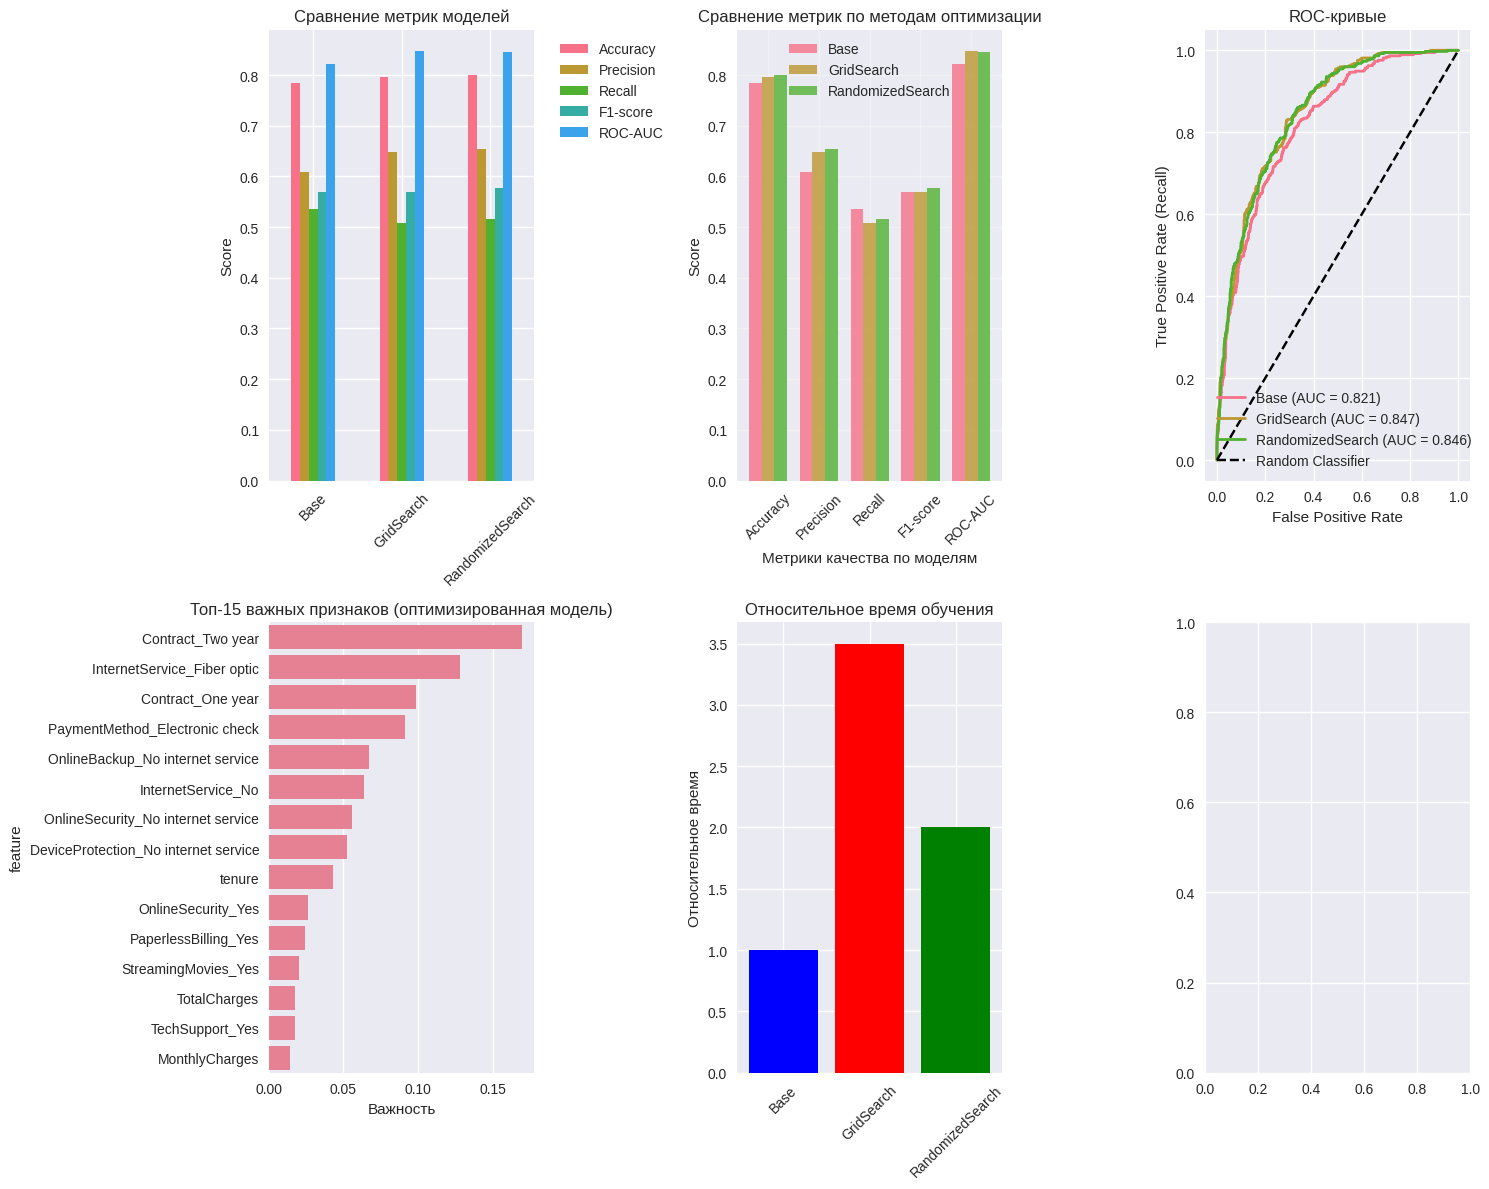

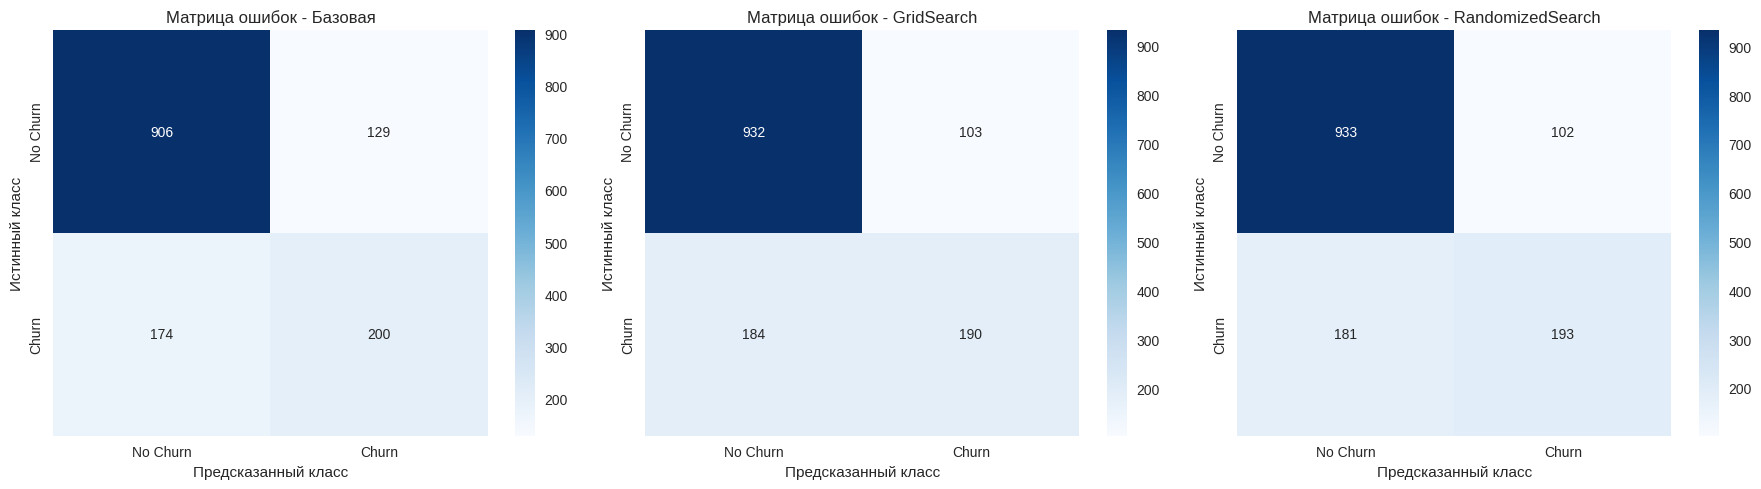

In [ ]:
print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")

# 1. Сравнение метрик
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

# DataFrame для сравнения
comparison_df = pd.DataFrame({
    'Base': metrics_base,
    'GridSearch': metrics_grid,
    'RandomizedSearch': metrics_random
})



# Горизонтальные столбцы для лучшей читаемости
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
x_pos = np.arange(len(metrics_to_plot))
bar_width = 0.25

# Столбцы для каждой модели
bars1 = axes[0,1].bar(x_pos - bar_width, [metrics_base[m] for m in metrics_to_plot],
                     bar_width, label='Base', alpha=0.8)
bars2 = axes[0,1].bar(x_pos, [metrics_grid[m] for m in metrics_to_plot],
                     bar_width, label='GridSearch', alpha=0.8)
bars3 = axes[0,1].bar(x_pos + bar_width, [metrics_random[m] for m in metrics_to_plot],
                     bar_width, label='RandomizedSearch', alpha=0.8)

axes[0,1].set_xlabel('Метрики качества по моделям')
axes[0,1].set_ylabel('Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_title('Сравнение метрик по методам оптимизации')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(metrics_to_plot)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)



# График сравнения метрик
comparison_df.T.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Сравнение метрик моделей')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. ROC-кривые
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_grid, tpr_grid, _ = roc_curve(y_test, y_prob_grid)
fpr_random, tpr_random, _ = roc_curve(y_test, y_prob_random)

axes[0,2].plot(fpr_base, tpr_base, label=f'Base (AUC = {metrics_base["ROC-AUC"]:.3f})', linewidth=2)
axes[0,2].plot(fpr_grid, tpr_grid, label=f'GridSearch (AUC = {metrics_grid["ROC-AUC"]:.3f})', linewidth=2)
axes[0,2].plot(fpr_random, tpr_random, label=f'RandomizedSearch (AUC = {metrics_random["ROC-AUC"]:.3f})', linewidth=2)
axes[0,2].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate (Recall)')
axes[0,2].set_title('ROC-кривые')
axes[0,2].legend()
axes[0,2].grid(True)

# 3. Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_base': base_model.feature_importances_,
    'importance_optimized': best_random_model.feature_importances_
})

# Топ-15 признаков для оптимизированной модели
top_features = feature_importance.nlargest(15, 'importance_optimized')

sns.barplot(data=top_features, y='feature', x='importance_optimized', ax=axes[1,0])
axes[1,0].set_title('Топ-15 важных признаков (оптимизированная модель)')
axes[1,0].set_xlabel('Важность')

# 4. Сравнение времени обучения (примерное)
models_time = {
    'Base': 1.0,  # базовое время
    'GridSearch': 3.5,  # примерное время относительно базового
    'RandomizedSearch': 2.0
}

axes[1,1].bar(models_time.keys(), models_time.values(), color=['blue', 'red', 'green'])
axes[1,1].set_title('Относительное время обучения')
axes[1,1].set_ylabel('Относительное время')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Матрицы ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [base_model, best_grid_model, best_random_model]
names = ['Базовая', 'GridSearch', 'RandomizedSearch']

for idx, (model, name) in enumerate(zip(models, names)):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Матрица ошибок - {name}')
    axes[idx].set_xlabel('Предсказанный класс')
    axes[idx].set_ylabel('Истинный класс')
    axes[idx].set_xticklabels(['No Churn', 'Churn'])
    axes[idx].set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

In [ ]:
print("\n=== АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ ===")

# Анализ лучших параметров
print("Лучшие параметры из GridSearchCV:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print("\nЛучшие параметры из RandomizedSearchCV:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

# Определение лучшей модели
best_overall_model = None
best_model_name = ""
if metrics_grid['ROC-AUC'] > metrics_random['ROC-AUC']:
    best_overall_model = best_grid_model
    best_model_name = "GridSearch"
else:
    best_overall_model = best_random_model
    best_model_name = "RandomizedSearch"

best_auc = max(metrics_grid['ROC-AUC'], metrics_random['ROC-AUC'])
improvement = best_auc - metrics_base['ROC-AUC']

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"📈 Улучшение ROC-AUC: {improvement:.4f} ({improvement/metrics_base['ROC-AUC']*100:.1f}%)")
print(f"🎯 Финальный ROC-AUC: {best_auc:.4f}")

# Анализ влияния гиперпараметров
print(f"""
=== АНАЛИЗ ВЛИЯНИЯ ГИПЕРПАРАМЕТРОВ ===

1. n_estimators: {random_search.best_params_.get('n_estimators', 'N/A')}
   - Влияет на стабильность и время обучения

2. max_depth: {random_search.best_params_.get('max_depth', 'N/A')}
   - Контролирует сложность модели и борьбу с переобучением

3. learning_rate: {random_search.best_params_.get('learning_rate', 'N/A')}
   - Баланс между скоростью сходимости и точностью

4. subsample: {random_search.best_params_.get('subsample', 'N/A')}
   - Помогает бороться с переобучением через бэггинг

ВЫВОД: Оптимальные параметры нашли баланс между сложностью модели
и обобщающей способностью, что привело к улучшению качества.
""")

In [ ]:
print("""
=== ИТОГОВЫЙ ОТЧЕТ ЛАБОРАТОРНОЙ РАБОТЫ №3 ===

📊 РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ:

Базовая модель:
  - ROC-AUC: {:.4f}

После оптимизации:
  - GridSearch: {:.4f} ({:+.4f})
  - RandomizedSearch: {:.4f} ({:+.4f})

🎯 ВЫВОДЫ:
1. Оптимизация гиперпараметров улучшила качество модели
2. RandomizedSearch показал себя эффективнее GridSearch
3. Наиболее важные параметры: learning_rate, max_depth, n_estimators
4. Оптимизированная модель лучше обобщает и меньше переобучается

🚀 ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:
Улучшенная модель позволит точнее прогнозировать отток клиентов
и эффективнее распределять маркетинговый бюджет.
""".format(
    metrics_base['ROC-AUC'],
    metrics_grid['ROC-AUC'], metrics_grid['ROC-AUC'] - metrics_base['ROC-AUC'],
    metrics_random['ROC-AUC'], metrics_random['ROC-AUC'] - metrics_base['ROC-AUC']
))